In [20]:
# RESTORE THE MODEL
from keras.models import model_from_json
from keras.preprocessing import image
import pickle
import cv2

def load_model(ar_path, w_path, cls_id_path):
    json_file = open(ar_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(w_path)
    loaded_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    with open(cls_id_path, 'rb') as handle:
        class2id = pickle.load(handle)
    # output result --> class number
    i2cls = {}
    for cls, i in class2id.items():
        i2cls[i] = int(cls)
    print("Restore model success")
    return loaded_model, i2cls


In [2]:
# Indices to labels
# need this because the output now is just a number
# i2label = {number: image}
with open('i2label.pkl', 'rb') as handle:
    i2label_kanji = pickle.load(handle)

In [57]:
def predict(img, model, i2cls, name='kanji'):
    #img = image.load_img(path=f'/Users/binhna/Downloads/test_image/kanji41.png',
    #                     grayscale=True, target_size = (64,64))
    #showimg(img, 'gold')
    #img = image.img_to_array(img)
    #img = img.astype(np.uint8)
    #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    result = model.predict_classes(img)
    print(f"class number: {result}")
    #showimg(i2label[i2cls[int(result)]], 'predict')
    #print(i2cls[int(result)])
    if name == 'kanji':
        return i2label_kanji[i2cls[int(result)]]
    else:
        return i2cls[int(result)]

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import close_morphology, naive_seg, smooth

class Splitter(object):
    def __init__(self):
        self.final_result = None

    def _compute_text_height(self, im):
        #closing morphology
        closing = close_morphology(im)
        #horizontal projection
        h_proj = np.sum(closing, axis=1)
        #compute text height
        sum_h_proj = np.sum(h_proj)
        max_h_proj = np.amax(h_proj)
        max_h_proj_idx = np.where(h_proj == max_h_proj)[0][0]
        cumsum = max_h_proj
        th_arr = np.array([max_h_proj_idx]) # text_height_arr
        while cumsum < (sum_h_proj * 0.99):
            left = h_proj[th_arr[0]]
            right = h_proj[th_arr[-1]]
            if left > right:
                cumsum += left
                th_arr = np.append(th_arr[0] - 1, th_arr)
            else:
                cumsum += right
                th_arr = np.append(th_arr, th_arr[-1] + 1)
        text_height = th_arr[-1] - th_arr[0]
        print(text_height)
        return text_height

    def _get_vertical_profile(self, im):
        v_prof = np.sum((255-im), axis=0)
        smoothed_prof = smooth(v_prof, 9)
        plt.plot(smoothed_prof)
        plt.show()
        return smoothed_prof

    def _segment_zero(self, v_proj_s):
        ''' Find all segment boundary lines '''
        flag = True
        tmp = []
        for i, value in enumerate(v_proj_s):
            if value != 0 and not flag:
                tmp.append(i-1)
            if value == 0. and flag:
                tmp.append(i)
                flag = False
            flag = True if value != 0. else False
        # Add 0 and len(vertical projection) to the list
        tmp.insert(0, 0) if 0 not in tmp else ''
        tmp.insert(len(tmp), len(v_proj_s) - 1) if len(v_proj_s) - \
            1 not in tmp else ''
        print('Number of zero segmentns: ' + str(len(tmp)))
        return tmp

    def _find_oversize(self, tmp, text_height, v_prof, ratio=0.8):
        ''' Find vertical boundary lines of oversized segments '''
        thres = round(text_height*ratio)
        oversize_seg = []
        if v_prof[0] == 0.:
            start = 1
        else:
            start = 0
        for i in range(start, len(tmp) - 1, 2):
            if tmp[i+1] - tmp[i] > thres:
                oversize_seg.append(tmp[i])
                oversize_seg.append(tmp[i+1])
        print('Number of oversize segments: ' + str(len(oversize_seg)))
        return oversize_seg

    def _find_local_max(self, v_prof, oversize_seg, text_height):
        ''' Find x-coordinate of local maxima in oversize segment '''
        local_max_arr = []
        for i in range(0, len(oversize_seg) - 1, 2):
            start, end = oversize_seg[i], oversize_seg[i+1]
            peaks, _ = find_peaks(v_prof[start:end], distance=text_height*0.5)
            peaks += start
            local_max_arr.append(peaks.tolist())
            for i in peaks:
                plt.axvline(x=i, color='g', linestyle='-')
        for i in oversize_seg:
            plt.axvline(x=i, color='r', linestyle='-')
        plt.show()
        print('Number of local maxima: ' + str(len(local_max_arr)))
        return local_max_arr

    def _smart_seg(self, arr_img, debug=False):
        ''' Split characters in image '''
        result = []
        regions = []
        tmp = arr_img[0][0]  # <- first CC
        bounding_left, bounding_right = arr_img[0][-1][0], arr_img[0][-1][0] + \
            arr_img[0][-1][2]
        bounding_top, bounding_bottom = arr_img[0][-1][1], arr_img[0][-1][1] + \
            arr_img[0][-1][3]
        condition = True
        for i_img in range(len(arr_img) - 1):
            i_next = i_img + 1
            x2 = bounding_right
            x1 = arr_img[i_next][-1][0]
            current_width = bounding_right - bounding_left
            current_height = bounding_bottom - bounding_top
            smaller_width = current_width if current_width < arr_img[
                i_next][-1][2] else arr_img[i_next][-1][2]
            smaller_height = current_height if current_height < arr_img[i_next][-1][3] else arr_img[i_next][-1][3]
            
            y_bottom_next = arr_img[i_next][-1][1] + arr_img[i_next][-1][3]
            tenten = arr_img[i_next][-1][3] < 0.45*(bounding_bottom - bounding_top) \
            and x1 - x2 < smaller_width*0.5
            # and y_bottom_next < 0.7*current_height+bounding_top \
            # and (y_bottom_next - bounding_top) > 0.5*smaller_height \
            #print(f"{arr_img[i_next][-1][3] < 0.45*(bounding_bottom - bounding_top)} \
            #{x1 - x2 < smaller_width*0.5} - {x1}")
            """print(f"{arr_img[i_next][-1][3] < 0.45*(bounding_bottom - bounding_top)} \
            {(y_bottom_next - bounding_top) > 0.5*smaller_height} \
            {y_bottom_next < 0.6*current_height+bounding_top} \
            {x1 - x2 < smaller_width*0.5} - {x1} - {arr_img[i_next][-1][3]}, {0.3*(bounding_bottom - bounding_top)}")"""
            # print(f"Debug tenten: {arr_img[i_next][-1][3]}, {bounding_bottom - bounding_top}, {y_bottom_next - bounding_top}, {smaller_height}")
            
            condition = (x2-x1) > 0.5*smaller_width or tenten
            if condition:
                bounding_left = min(bounding_left, arr_img[i_next][-1][0])
                bounding_top = min(bounding_top, arr_img[i_next][-1][1])
                bounding_right = max(
                    bounding_right, arr_img[i_next][-1][0]+arr_img[i_next][-1][2])
                bounding_bottom = max(
                    bounding_bottom, arr_img[i_next][-1][1]+arr_img[i_next][-1][3])
                tmp = tmp | arr_img[i_next][0]
            else:
                regions.append((bounding_left, bounding_top,
                            bounding_right, bounding_bottom))
                result.append(tmp)
                tmp = arr_img[i_next][0]
                bounding_left, bounding_right = arr_img[i_next][-1][0], arr_img[i_next][-1][0] + \
                    arr_img[i_next][-1][2]
                bounding_top, bounding_bottom = arr_img[i_next][-1][1], arr_img[i_next][-1][1] + \
                    arr_img[i_next][-1][3]
        regions.append((bounding_left, bounding_top,
                    bounding_right, bounding_bottom))
        if condition:
            result.append(tmp)
        else:
            result.append(arr_img[-1][0])
        print('Number of smart seg: ' + str(len(result)))
        return result, regions

    def _remove_padding(self, res, regions):
        ''' Filter small CCs and remove padding around characters '''
        final_result = []
        for i in range(len(regions)):
            x1 = regions[i][0]
            y1 = regions[i][1]
            x2 = regions[i][2]
            y2 = regions[i][3]
            if (x2-x1 > 3).any() and (y2-y1 > 3).any():
                cut = res[i][y1:y2, x1:x2]
                small = 0 if cut.shape[0] < cut.shape[1] else 1
                large = 1 - small
                padding = (cut.shape[large] - cut.shape[small])//2
                padding = np.zeros((padding, cut.shape[large])) if large else np.zeros(
                    (cut.shape[large], padding))
                tmp_img = np.concatenate(
                    (padding, cut, padding), axis=small)
                final_result.append(tmp_img)
        return final_result

    def split(self, im, debug = False):
        text_height = self._compute_text_height(im)
        v_prof = self._get_vertical_profile(im)
        boundary_seg = self._segment_zero(v_prof)
        plt.imshow(im, cmap='gray')
        for i in boundary_seg:
            plt.axvline(x=i, color='r', linestyle='-')
        plt.show()

        oversize_seg = self._find_oversize(boundary_seg, text_height, v_prof, 0.8)
        plt.imshow(im, cmap='gray')
        for i in oversize_seg:
            plt.axvline(x=i, color='r', linestyle='-')
        plt.show()

        local_max_arr = self._find_local_max(v_prof, oversize_seg, text_height)
        im_arr = naive_seg(255-im, debug)

        result, regions = self._smart_seg(im_arr)
        final_result = self._remove_padding(result, regions)
        return final_result


In [44]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def showimg(img, title=''):
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}")
    plt.show()

def naive_seg(im, debug=False):
    ''' split input image to a list of segments in ascending order of x-coordinate '''
    count = 0
    im_arr = []
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats( im.astype(np.uint8), connectivity=8)
    for i in range(1, ret):
        if(stats[i][cv2.CC_STAT_WIDTH] > 3).any() and (stats[i][cv2.CC_STAT_HEIGHT] > 3).any():
            count+=1
            new_im = np.zeros_like(im)
            new_im[labels == i] = 255
            im_arr.append((new_im, stats[i]))
    im_arr = sorted(im_arr, key=lambda x: x[-1][0])
    print('Number of naive seg: ' + str(len(im_arr)))

    if debug:
        img_debug = 255 - im.copy()
        for i in im_arr:
            x, y, w, h = i[1][:4]
            im2 = cv2.rectangle(img_debug, (x, y), (x+w, y+h), (0, 255, 0), 1)
        showimg(im2, 'Debug - Naive')
    return im_arr

def close_morphology(im):
    ''' Closing morphology '''
    kernel = np.ones((3,20), np.uint8)
    closing = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    return closing

def smooth(prof, kernel = 7):
    ''' Smooth out a profile using moving average '''
    padd = int((kernel-1)/2)
    v_proj = np.concatenate([[0.]*padd, prof, [0.]*padd])
    v_proj_s = [sum(v_proj[i:i+kernel])/7. for i, element in enumerate(v_proj[:-kernel+1])]
    v_proj_s = np.asarray(v_proj_s, dtype=np.float32)
    return v_proj_s


In [6]:
def to_bin(path):
    image = cv2.imread(path, 0)
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image

def showimg(img, title=''):
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}")
    plt.show()

In [22]:
# KANJI MODEL
kanji_json = '/Users/binhna/Downloads/JRead/engine/saved_models/kanji_model_keras.json'
kanji_weight = "/Users/binhna/Downloads/JRead/engine/saved_models/kanji_model_keras.h5"
kanji_class_indices = '/Users/binhna/Downloads/JRead/engine/saved_models/class_indices_kanji.pickle'
kanji_model, i2cls_kanji = load_model(kanji_json, kanji_weight, kanji_class_indices)

Restore model success


In [21]:
# KATAKANA MODEL
kata_json = '/Users/binhna/Downloads/JRead/engine/saved_models/katakana_model_keras.json'
kata_weight = "/Users/binhna/Downloads/JRead/engine/saved_models/katakana_model_keras.h5"
kata_class_indices = '/Users/binhna/Downloads/JRead/engine/saved_models/kata_class_indices.pickle'
kata_model, i2cls_kata = load_model(kata_json, kata_weight, kata_class_indices)
code_label_kata = {185: 'ケ', 186: 'コ', 187: 'サ', 188: 'シ', 189: 'ス', 190: 'セ', 191: 'ソ', 192: 'タ', 177: 'ア', 178: 'イ', 179: 'ウ', 180: 'エ', 181: 'オ', 182: 'カ', 183: 'キ', 184: 'ク', 193: 'チ', 194: 'ツ', 195: 'テ', 196: 'ト', 197: 'ナ', 198: 'ニ', 199: 'ヌ', 200: 'ネ', 170: 'ヱ', 166: 'ヲ', 221: 'ン', 215: 'ラ', 216: 'リ', 217: 'ル', 218: 'レ', 219: 'ロ', 220: 'ワ', 168: 'ヰ', 201: 'ノ', 202: 'ハ', 203: 'ヒ', 204: 'フ', 205: 'ヘ', 206: 'ホ', 207: 'マ', 208: 'ミ', 209: 'ム', 210: 'メ', 211: 'モ', 212: 'ヤ', 213: 'ユ', 214: 'ヨ'}



Restore model success


In [23]:
print(type(kanji_model))

<class 'keras.engine.sequential.Sequential'>


In [33]:
splt = Splitter()

def app(img_path, model, i2cls, name='kanji'):
    image = to_bin(img_path)

    im_arr = naive_seg(255-image)
    result, regions = splt._smart_seg(im_arr)

    img_debug = image.copy()
    for r in regions:
        x1, y1, x2, y2 = r
        im2 = cv2.rectangle(img_debug, (x1, y1), (x2, y2), (0, 255, 0), 5)
        # showimg(img_debug[y1:y2, x1:x2])
    showimg(im2, 'Debug - Smart')
    
    vis = np.ones(shape=[103, 1], dtype=np.uint8)*255
    final = f''
    for i, r in zip(result, regions):
        x1, y1, x2, y2 = r
        #print(i[y1:y2, x1:x2].shape)
        # print(255 - i[y1:y2, x1:x2])
        tmp = predict(255 - i[y1:y2, x1:x2], model, i2cls, name)
        if name == 'kanji':
            vis = np.concatenate((vis, tmp), axis=1)
        elif name == 'kata':
            final+=f"{code_label_kata[tmp]} "
        else:
            final+=f"{code_label_hira[tmp]} "
    showimg(image, 'input')
    if name == 'kanji':
        showimg(vis, 'output')
    else:
        print(final)

Number of naive seg: 10
Number of smart seg: 6


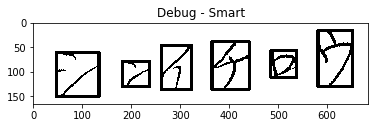

class number: [47]
class number: [47]
class number: [41]
class number: [19]
class number: [45]
class number: [5]


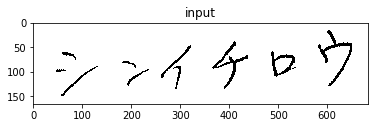

ン ン ラ チ ロ ウ 
Number of naive seg: 2
Number of smart seg: 2


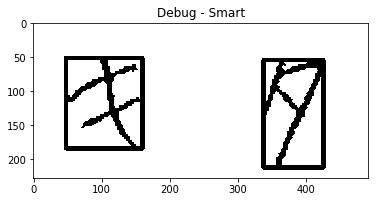

class number: [9]
class number: [18]


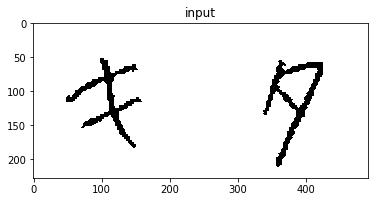

キ タ 
Number of naive seg: 3
Number of smart seg: 3


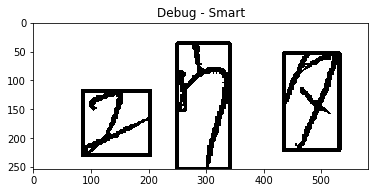

class number: [44]
class number: [5]
class number: [25]


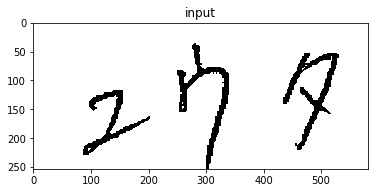

レ ウ ヌ 
Number of naive seg: 3
Number of smart seg: 3


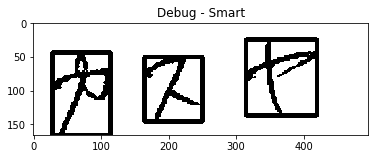

class number: [26]
class number: [15]
class number: [38]


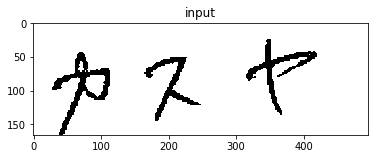

ネ ス ヤ 
Number of naive seg: 9
Number of smart seg: 6


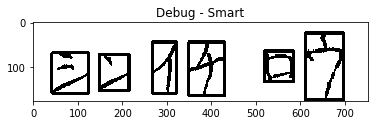

class number: [14]
class number: [47]
class number: [33]
class number: [19]
class number: [45]
class number: [5]


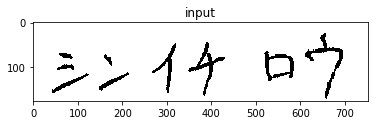

シ ン マ チ ロ ウ 
Number of naive seg: 2
Number of smart seg: 2


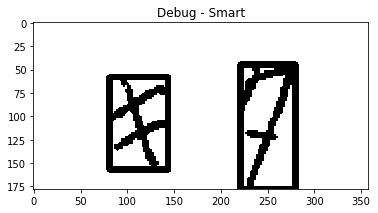

class number: [9]
class number: [25]


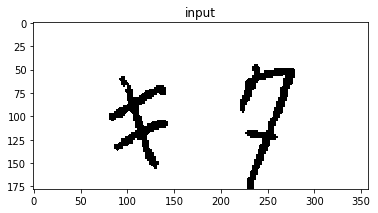

キ ヌ 
Number of naive seg: 3
Number of smart seg: 3


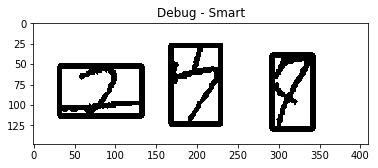

class number: [39]
class number: [41]
class number: [15]


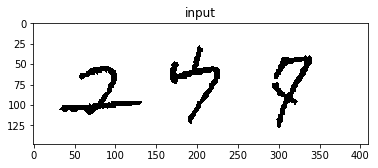

ユ ラ ス 
Number of naive seg: 3
Number of smart seg: 3


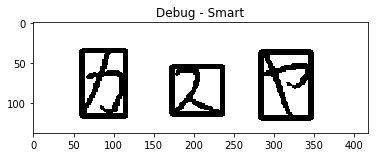

class number: [8]
class number: [15]
class number: [38]


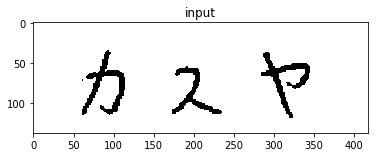

カ ス ヤ 
Number of naive seg: 4
Number of smart seg: 4


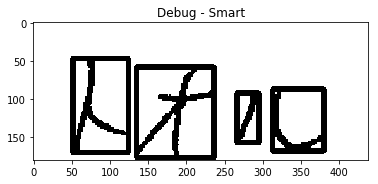

class number: [35]
class number: [7]
class number: [9]
class number: [44]


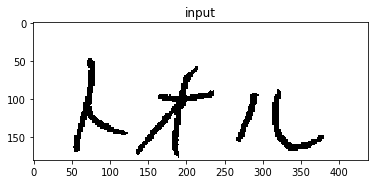

ム オ キ レ 


In [64]:
for i in range(13, 22):
    p = f'/Users/binhna/Downloads/test_image/kata_{i}.png'
    #print(p)
    app(p, kata_model, i2cls_kata, 'kata')


